# RQ2 — Modalidad de trabajo y salario (modelo ajustado)

**RQ2:** ¿Se mantiene la asociación entre modalidad de trabajo `RemoteWork` y salario al controlar por **país**, **experiencia**, **educación** y **rol**?

En este notebook construiremos un subdataset “oficial” para RQ2 y luego estimaremos modelos de regresión por bloques (M0→M3) para ver cómo cambia el efecto de `RemoteWork` cuando añadimos controles.


RQ2 busca una **asociación ajustada**: comparar salarios entre modalidades de trabajo como si estuviéramos comparando personas con el mismo país, experiencia, educación y rol.  
La herramienta para hacer esto de forma escalable es una **regresión múltiple**, donde `RemoteWork` es la variable principal y el resto son controles.


In [ ]:
#  Carga del dataset procesado + shape original
import pandas as pd
import numpy as np

DATA_PATH = "../data/processed/df_final_v1.csv"

df = pd.read_csv(DATA_PATH)

print("Shape original (processed):", df.shape)
display(df.head(3))


Shape original (processed): (65437, 20)


,ResponseId,MainBranch,Employment,Country,RemoteWork,ConvertedCompYearly,YearsCodePro,YearsCode,DevType,EdLevel,Age,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,WebframeHaveWorkedWith,PlatformHaveWorkedWith,ToolsTechHaveWorkedWith,has_salary,YearsCodePro_num,log_salary
0,1,I am a developer by profession,"Employed, full-time",United States of America,Remote,NaN,NaN,NaN,NaN,Primary/elementary school,Under 18 years old,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
1,2,I am a developer by profession,"Employed, full-time",United Kingdom of Great Britain and Northern I...,Remote,NaN,17,20,"Developer, full-stack","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",35-44 years old,NaN,Bash/Shell (all shells);Go;HTML/CSS;Java;JavaS...,Dynamodb;MongoDB;PostgreSQL,Express;Next.js;Node.js;React,Amazon Web Services (AWS);Heroku;Netlify,Docker;Homebrew;Kubernetes;npm;Vite;Webpack,False,17.0,NaN
2,3,I am a developer by profession,"Employed, full-time",United Kingdom of Great Britain and Northern I...,Remote,NaN,27,37,Developer Experience,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",45-54 years old,NaN,C#,Firebase Realtime Database,ASP.NET CORE,Google Cloud,MSBuild,False,27.0,NaN


In [ ]:
# Filtro por has_salary (salario reportado)

df_salary = df[df["has_salary"]].copy()
print("Shape tras filtrar has_salary=True:", df_salary.shape)


Shape tras filtrar has_salary=True: (23435, 20)


In [4]:
# Variables con muy pocos registros (diagnóstico rápido)
# Para RQ2 necesitamos además RemoteWork (modalidad). Creamos una versión sin NA en RemoteWork.
df_rq2_base = df_salary[df_salary["RemoteWork"].notna()].copy()
print("Shape con has_salary y RemoteWork no nulo:", df_rq2_base.shape)

# ---- Países con pocos registros (en la muestra salarial + modalidad) ----
country_counts = df_rq2_base["Country"].value_counts()
print("\nPaíses menos frecuentes:")
display(country_counts.tail(10))

# ---- Roles (DevType) con pocos registros ----
dev_counts = df_rq2_base["DevType"].value_counts()
print("\nRoles menos frecuentes:")
display(dev_counts.tail(10))

ed_counts = df_rq2_base["EdLevel"].value_counts()
print("\nNiveles educativos menos frecuentes:")
display(ed_counts.tail(10))

# ---- Experiencia (YearsCodePro_num) es numérica: la binned para ver zonas con pocos casos ----
if "YearsCodePro_num" in df_rq2_base.columns:
    exp_bins = pd.cut(df_rq2_base["YearsCodePro_num"], bins=[-0.01, 0.5, 1, 3, 5, 10, 20, 30, 40, 60])
    exp_bin_counts = exp_bins.value_counts().sort_index()
    print("\nDistribución de experiencia (binned):")
    display(exp_bin_counts)


# ---- Tablas cruzadas para ver soporte por país/rol vs modalidad ----
RW_HYB = "Hybrid (some remote, some in-person)"
RW_INP = "In-person"
RW_REM = "Remote"

ct_country = pd.crosstab(df_rq2_base["Country"], df_rq2_base["RemoteWork"])
for col in [RW_HYB, RW_INP, RW_REM]:
    if col not in ct_country.columns:
        ct_country[col] = 0
ct_country["total"] = ct_country[[RW_HYB, RW_INP, RW_REM]].sum(axis=1)
ct_country["n_modalities_present"] = (ct_country[[RW_HYB, RW_INP, RW_REM]] > 0).sum(axis=1)

print("\n¿Cuántos países tienen 1/2/3 modalidades presentes?")
display(ct_country["n_modalities_present"].value_counts().sort_index())


Shape con has_salary y RemoteWork no nulo: (23427, 20)

Países menos frecuentes:


Country
Oman                        1
Central African Republic    1
Samoa                       1
Antigua and Barbuda         1
Lesotho                     1
Brunei Darussalam           1
Burundi                     1
Barbados                    1
Mali                        1
Haiti                       1
Name: count, dtype: int64


Roles menos frecuentes:


DevType
Security professional              113
Educator                           108
Blockchain                          92
Developer Experience                88
Product manager                     87
Hardware Engineer                   65
Database administrator              59
Developer Advocate                  52
Designer                            44
Marketing or sales professional     17
Name: count, dtype: int64


Niveles educativos menos frecuentes:


EdLevel
Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          10363
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                        6827
Some college/university study without earning a degree                                 2793
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     1184
Professional degree (JD, MD, Ph.D, Ed.D, etc.)                                         1155
Associate degree (A.A., A.S., etc.)                                                     749
Something else                                                                          209
Primary/elementary school                                                               147
Name: count, dtype: int64


Distribución de experiencia (binned):


YearsCodePro_num
(-0.01, 0.5]       0
(0.5, 1.0]       971
(1.0, 3.0]      3741
(3.0, 5.0]      3312
(5.0, 10.0]     6305
(10.0, 20.0]    5481
(20.0, 30.0]    2124
(30.0, 40.0]     622
(40.0, 60.0]     111
Name: count, dtype: int64


¿Cuántos países tienen 1/2/3 modalidades presentes?


n_modalities_present
1     25
2     27
3    114
Name: count, dtype: int64

### Análisis del caso de los países
Controlar por país implica que el modelo aprenderá un “nivel base” salarial para cada país.  
Si incluimos países con muy pocos registros o con ausencia de alguna modalidad (por ejemplo, 0 personas In-person), el modelo puede volverse **inestable**: no hay suficiente información para separar “efecto país” vs “efecto modalidad”.

Por eso, antes de modelar, definimos un criterio de **soporte mínimo** por país:
- un mínimo de observaciones totales (`MIN_TOTAL`),
- un mínimo de observaciones **In-person** (`MIN_INPERSON`) para asegurar comparabilidad,
- y presencia de las 3 modalidades.


In [ ]:
# Construcción del subdataset oficial (países “buenos” + columnas de interés)

MIN_TOTAL = 100
MIN_INPERSON = 20

ct_country_sorted = ct_country.sort_values("total", ascending=False)

good_countries = ct_country_sorted[
    (ct_country_sorted["total"] >= MIN_TOTAL) &
    (ct_country_sorted[RW_INP] >= MIN_INPERSON) &
    (ct_country_sorted["n_modalities_present"] == 3)
].index

cols_interest = [
    "Country", "RemoteWork", "EdLevel", "DevType",
    "YearsCodePro_num", "log_salary", "ConvertedCompYearly", "has_salary"
]

df_rq2_official = (
    df_rq2_base[df_rq2_base["Country"].isin(good_countries)]
    [cols_interest]
    .copy()
)

print("Países retenidos:", len(good_countries))
print("Filas antes:", len(df_rq2_base))
print("Filas después (subdataset oficial):", len(df_rq2_official))


Países retenidos: 32
Filas antes: 23427
Filas después (subdataset oficial): 19932


In [6]:
# Shape del subdataset oficial + distribución de RemoteWork
print("Shape subdataset oficial:", df_rq2_official.shape)

print("\nDistribución de RemoteWork (subdataset oficial):")
display(df_rq2_official["RemoteWork"].value_counts())

print("\n% por modalidad:")
display((df_rq2_official["RemoteWork"].value_counts(normalize=True)*100).round(2))


Shape subdataset oficial: (19932, 8)

Distribución de RemoteWork (subdataset oficial):


RemoteWork
Hybrid (some remote, some in-person)    8630
Remote                                  8147
In-person                               3155
Name: count, dtype: int64


% por modalidad:


RemoteWork
Hybrid (some remote, some in-person)    43.30
Remote                                  40.87
In-person                               15.83
Name: proportion, dtype: float64

### Sobre el desbalance relativo de In-person
En datos reales es común que `In-person` tenga menos registros que `Hybrid` o `Remote`.  
Esto **no invalida** el análisis ya que:
- el grupo In-person sigue siendo numéricamente grande (>3000 observaciones),
- existe solapamiento por país/rol (no hay “celdas vacías” masivas),
- y se reportarán intervalos de confianza (incertidumbre) junto al efecto estimado.

En fases posteriores, además, verificamos robustez (por ejemplo, agrupando roles raros) y revisamos diagnósticos de residuos.


## Modelado

### Explicación básica

En RQ2 usamos regresión **(OLS)** porque queremos medir el efecto de `RemoteWork` **ajustando** por país, experiencia, educación y rol.

`RemoteWork`, `Country`, `EdLevel` y `DevType` son categóricas. El modelo las transforma internamente en variables 0/1 (dummies). Para una variable con *k* categorías se usan *k−1* dummies, dejando una categoría como referencia.

**Categoría base:** elegimos `In-person` como referencia para interpretar directamente:
- `Hybrid` vs `In-person`
- `Remote` vs `In-person`

**Errores robustos (HC3):** los datos salariales suelen presentar heterocedasticidad (dispersión no constante). HC3 ajusta los errores estándar para hacer inferencia (p-values e IC) más confiable.


In [7]:
# Pre-modelado: filas completas para el modelo
needed = ["log_salary", "RemoteWork", "Country", "YearsCodePro_num", "EdLevel", "DevType"]
df_rq2_model = df_rq2_official.dropna(subset=needed).copy()

print("Filas subdataset oficial:", len(df_rq2_official))
print("Filas completas para modelar:", len(df_rq2_model))
print("Eliminadas por NA en controles:", len(df_rq2_official)-len(df_rq2_model))

print("\nDistribución RemoteWork (df_rq2_model):")
display(df_rq2_model["RemoteWork"].value_counts())


Filas subdataset oficial: 19932
Filas completas para modelar: 19287
Eliminadas por NA en controles: 645

Distribución RemoteWork (df_rq2_model):


RemoteWork
Hybrid (some remote, some in-person)    8388
Remote                                  7964
In-person                               2935
Name: count, dtype: int64

In [8]:
# Función para resumir solo el efecto de RemoteWork
import numpy as np
import pandas as pd

def remote_effects(model):
    coefs = model.params.filter(like="RemoteWork")
    ci = model.conf_int().loc[coefs.index]
    out = pd.DataFrame({
        "beta_log": coefs,
        "pct_effect": 100*(np.exp(coefs)-1),
        "ci_low_pct": 100*(np.exp(ci[0])-1),
        "ci_high_pct": 100*(np.exp(ci[1])-1),
        "p_value": model.pvalues.loc[coefs.index]
    })
    return out

In [9]:
# Modelo M0 + tabla remote_effects
import statsmodels.formula.api as smf

RW_INP = "In-person"
rw_term = f'C(RemoteWork, Treatment(reference="{RW_INP}"))'

m0 = smf.ols(
    f"log_salary ~ {rw_term}",
    data=df_rq2_model
).fit(cov_type="HC3")


print(m0.summary())
display(remote_effects(m0))


                            OLS Regression Results                            
Dep. Variable:             log_salary   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     137.1
Date:                Fri, 02 Jan 2026   Prob (F-statistic):           7.88e-60
Time:                        14:33:26   Log-Likelihood:                -31657.
No. Observations:               19287   AIC:                         6.332e+04
Df Residuals:                   19284   BIC:                         6.334e+04
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                                                                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

,beta_log,pct_effect,ci_low_pct,ci_high_pct,p_value
"C(RemoteWork, Treatment(reference=""In-person""))[T.Hybrid (some remote, some in-person)]",0.439156,55.139743,46.996258,63.734371,2.300513e-57
"C(RemoteWork, Treatment(reference=""In-person""))[T.Remote]",0.440492,55.347093,46.700250,64.503600,2.368495e-51


### Análisis de M0 (modelo crudo)

En **M0** ajustamos una regresión OLS donde la única variable explicativa es `RemoteWork`, usando **In-person** como categoría de referencia y **errores estándar robustos HC3**.  
Este modelo sirve como **línea base**: cuantifica la diferencia promedio de salario entre modalidades **sin** controlar por país, experiencia, educación o rol.

---

#### Interpretación de los coeficientes (Hybrid/Remote vs In-person)

El modelo tiene la forma:


$$
\begin{aligned}
\mathrm{log\_salary} &= \beta_0 + \beta_H \, \mathbb{1}(\mathrm{Hybrid}) + \beta_R \, \mathbb{1}(\mathrm{Remote}) + \varepsilon
\end{aligned}
$$


- **Intercept (β₀ = 10.5785)**: representa el **promedio de `log_salary`** para el grupo **In-person** (categoría base).
- **βH (Hybrid vs In-person = 0.4392)**: diferencia promedio en `log_salary` entre **Hybrid** e **In-person**.
- **βR (Remote vs In-person = 0.4405)**: diferencia promedio en `log_salary` entre **Remote** e **In-person**.

Como `log_salary = log(1 + salario)`, es más interpretable expresar los coeficientes como cambios porcentuales aproximados:

$$
\%\Delta \approx 100 \, (e^{\beta} - 1)
$$

Con tus resultados (`remote_effects(M0)`):

- **Hybrid vs In-person**:  
  - β = **0.439156** → **+55.14%**  
  - IC95%: **[+47.00%, +63.73%]**  
  - p-value: **2.30e−57**
- **Remote vs In-person**:  
  - β = **0.440492** → **+55.35%**  
  - IC95%: **[+46.70%, +64.50%]**  
  - p-value: **2.37e−51**

En el análisis crudo, **Hybrid y Remote se asocian con salarios ~55% mayores** que In-person (en promedio), y la evidencia estadística es muy fuerte (p-values extremadamente pequeños).

Un detalle adicional: los coeficientes de **Hybrid** y **Remote** son casi iguales en M0 (≈0.439 vs ≈0.440), lo que sugiere que en la muestra cruda ambos grupos tienen un nivel promedio de `log_salary` **muy similar** entre sí, y ambos están por encima de In-person.

---

Este modelo es **unadjusted**: no incluye controles por `Country`, `YearsCodePro_num`, `EdLevel` ni `DevType`.  
Por tanto:

- **Sí** podemos concluir: existe una **asociación cruda** entre `RemoteWork` y salario (en log) en la muestra analizada.
- **No** podemos concluir: que el trabajo remoto/híbrido **cause** un mayor salario.  
  La diferencia puede estar parcialmente explicada por **confusión** (p. ej., distintos países, distintos roles, distinta experiencia).

Esto también se refleja en el **R² = 0.016**: `RemoteWork` por sí sola explica una parte pequeña de la variabilidad del salario, lo cual es esperable en datos salariales (hay muchos factores adicionales relevantes).

> En resumen: M0 es el “antes de ajustar”. Útil para tener un punto de partida, pero todavía no responde RQ2.


In [ ]:
# Modelo M1 (añadiendo experiencia) + remote_effects
m1 = smf.ols(
    f"log_salary ~ {rw_term} + YearsCodePro_num",
    data=df_rq2_model
).fit(cov_type="HC3")

print(m1.summary())
display(remote_effects(m1))


                            OLS Regression Results                            
Dep. Variable:             log_salary   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     939.8
Date:                Fri, 02 Jan 2026   Prob (F-statistic):               0.00
Time:                        14:34:04   Log-Likelihood:                -30633.
No. Observations:               19287   AIC:                         6.127e+04
Df Residuals:                   19283   BIC:                         6.131e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                                                                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

,beta_log,pct_effect,ci_low_pct,ci_high_pct,p_value
"C(RemoteWork, Treatment(reference=""In-person""))[T.Hybrid (some remote, some in-person)]",0.366641,44.287957,37.119785,51.830857,3.671428e-45
"C(RemoteWork, Treatment(reference=""In-person""))[T.Remote]",0.292909,34.032095,26.895450,41.570107,9.377222e-26


### Análisis de M1

En **M1** extendemos el modelo crudo (M0) añadiendo **experiencia profesional** (`YearsCodePro_num`) como covariable numérica. La especificación es:

$$
\mathrm{log\_salary} \sim \mathrm{RemoteWork} + \mathrm{YearsCodePro\_num}
$$

donde `RemoteWork` se modela como variable categórica con **In-person** como referencia y se utilizan **errores estándar robustos (HC3)**.

---

#### ¿Cuánto cambia el efecto de RemoteWork al controlar por experiencia?

Comparando M0 (sin controles) con M1 (controlando por experiencia), el “premium” asociado a `RemoteWork` se reduce de forma clara:

- **Hybrid vs In-person**
  - M0: **+55.14%** (IC95%: 47.00%–63.73%)
  - M1: **+44.29%** (IC95%: 37.12%–51.83%)

- **Remote vs In-person**
  - M0: **+55.35%** (IC95%: 46.70%–64.50%)
  - M1: **+34.03%** (IC95%: 26.90%–41.57%)

**Interpretación:** al incluir experiencia, parte de la diferencia cruda entre modalidades se “absorbe” por `YearsCodePro_num`. Esto indica que los grupos (Remote/Hybrid/In-person) no tienen la misma distribución de experiencia y que la experiencia está correlacionada con el salario. En otras palabras, una fracción del efecto observado en M0 era **confusión por experiencia**.

Aun así, en M1 los efectos de `RemoteWork` permanecen:
- **positivos**,
- con **IC95% completamente por encima de 0**, y
- con **p-values extremadamente pequeños**,

lo que sugiere que incluso comparando personas con niveles similares de experiencia (en promedio), `RemoteWork` sigue asociado a mayores salarios respecto a In-person.

---

#### Interpretación del coeficiente de `YearsCodePro_num`

En el `summary()` de M1, el coeficiente estimado para `YearsCodePro_num` es:

- **β = 0.0460** (en escala `log_salary`), con p ≪ 0.001.

Como la variable dependiente está en log, el coeficiente se interpreta (aproximadamente) como un cambio porcentual por cada año adicional de experiencia:

$$
\%\Delta \approx 100 \, (e^{0.0460} - 1)
$$

$$
e^{0.0460} \approx 1.047 \Rightarrow \%\Delta \approx 4.7\%
$$

**Lectura:** manteniendo constante la modalidad de trabajo, **un año adicional de experiencia profesional** se asocia con un incremento aproximado de **~4.7%** en el salario (en promedio), bajo este modelo.


---

#### Comentario sobre ajuste global

En M1, **R² ≈ 0.115**, lo que representa un aumento sustancial frente a M0 (R² ≈ 0.016). Esto es esperable: la experiencia explica una porción relevante de la variación salarial y mejora notablemente el ajuste del modelo, incluso sin incorporar todavía educación, rol y país.

---

#### Conclusión parcial 

M1 muestra que **controlar por experiencia reduce** el efecto crudo de `RemoteWork`, especialmente para la categoría **Remote**, pero no lo elimina. El siguiente paso (M2) evaluará si educación y rol explican parte adicional del efecto; finalmente, M3 incorporará país, que suele ser un confusor clave en salarios.


In [11]:
# Modelo M2 (experiencia + educación + rol) + remote_effects
m2 = smf.ols(
    f"log_salary ~ {rw_term} + YearsCodePro_num + C(EdLevel) + C(DevType)",
    data=df_rq2_model
).fit(cov_type="HC3")

print(m2.summary())
display(remote_effects(m2))


                            OLS Regression Results                            
Dep. Variable:             log_salary   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     82.77
Date:                Fri, 02 Jan 2026   Prob (F-statistic):               0.00
Time:                        14:34:58   Log-Likelihood:                -30320.
No. Observations:               19287   AIC:                         6.073e+04
Df Residuals:                   19243   BIC:                         6.107e+04
Df Model:                          43                                         
Covariance Type:                  HC3                                         
                                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

,beta_log,pct_effect,ci_low_pct,ci_high_pct,p_value
"C(RemoteWork, Treatment(reference=""In-person""))[T.Hybrid (some remote, some in-person)]",0.357384,42.958543,35.878724,50.407249,2.895749e-43
"C(RemoteWork, Treatment(reference=""In-person""))[T.Remote]",0.294592,34.257827,27.017664,41.910688,2.108032e-25


### Análisis de M2 

En **M2** ampliamos el modelo M1 incorporando dos bloques de variables categóricas: **educación** (`EdLevel`) y **rol** (`DevType`). La especificación es:

$$
\mathrm{log\_salary} \sim \mathrm{RemoteWork} + \mathrm{YearsCodePro\_num} + \mathrm{EdLevel} + \mathrm{DevType}
$$

donde `RemoteWork` se codifica con **In-person** como categoría de referencia y la inferencia se realiza con **errores estándar robustos HC3**.

---

#### ¿Cómo cambian los coeficientes de RemoteWork al añadir educación y rol?

Comparando **M1 → M2** se observa que el efecto estimado de `RemoteWork` cambia **muy poco**, lo que sugiere que, una vez controlada la experiencia, añadir educación y rol no “absorbe” gran parte adicional del efecto asociado a la modalidad de trabajo:

- **Hybrid vs In-person**
  - M1: **+44.29%** (IC95%: 37.12%–51.83%)
  - M2: **+42.96%** (IC95%: 35.88%–50.41%)

- **Remote vs In-person**
  - M1: **+34.03%** (IC95%: 26.90%–41.57%)
  - M2: **+34.26%** (IC95%: 27.02%–41.91%)

**Lectura técnica:** al incorporar `EdLevel` y `DevType`, el “premium” asociado a `RemoteWork` permanece **positivo** y con **intervalos de confianza completamente por encima de 0**, con p-values extremadamente pequeños. Esto indica que, en esta etapa, la asociación entre modalidad de trabajo y salario **no parece explicarse principalmente** por diferencias de educación o rol (condicionando ya por experiencia).

---

#### Comentario sobre dummies de `EdLevel` y `DevType`

Tanto `EdLevel` como `DevType` son variables **categóricas**. En una regresión lineal, esto implica que se transforman en un conjunto de variables binarias indicadoras (dummies) para poder incorporarlas al modelo:

- Si una variable tiene \(k\) categorías, el modelo crea \(k-1\) dummies y deja **una categoría omitida** como **referencia** (baseline).
- Cada coeficiente `C(EdLevel)[T.X]` se interpreta como:
  > Diferencia esperada en `log_salary` entre el nivel educativo **X** y el nivel educativo **de referencia**, manteniendo constantes `RemoteWork`, `YearsCodePro_num` y `DevType`.

- De forma análoga, cada coeficiente `C(DevType)[T.Y]` representa:
  > Diferencia esperada en `log_salary` entre el rol **Y** y el rol **de referencia**, manteniendo constantes `RemoteWork`, experiencia y educación.

**Implicaciones prácticas:**
1) **La interpretación siempre es relativa a la categoría base**: el `summary()` no da “salarios absolutos” por educación/rol, sino diferencias respecto al baseline omitido.
2) **Precaución con categorías pequeñas**: algunas categorías de rol/educación pueden tener pocos casos; esto tiende a aumentar la incertidumbre de sus coeficientes (errores estándar más grandes). En este proyecto se verificó que roles muy raros no alteran de forma relevante el estimado de `RemoteWork` (análisis de robustez).

---

#### Interpretación puntual (ejemplos ilustrativos desde el `summary()`)

En el output de M2 aparecen varios términos como:
- `C(EdLevel)[T.Bachelor’s degree ...]` con coeficiente positivo,
- `C(EdLevel)[T.Primary/elementary school]` con coeficiente negativo,
- `C(DevType)[T.Blockchain]` con coeficiente positivo,

lo cual es consistente con patrones esperables: mayores niveles educativos y ciertos roles suelen asociarse a salarios más altos en promedio. Sin embargo, estos coeficientes deben leerse **como diferencias contra la categoría base omitida**, no como ranking absoluto entre todas las categorías.

---

M2 muestra que, tras controlar por experiencia, añadir educación y rol **aumenta el ajuste global** del modelo, pero el efecto de `RemoteWork` permanece de magnitud similar a M1 y estadísticamente robusto. 

In [17]:
# Modelo M3 (final: + país) + remote_effects
m3 = smf.ols(
    f"log_salary ~ {rw_term} + YearsCodePro_num + C(EdLevel) + C(DevType) + C(Country)",
    data=df_rq2_model
).fit(cov_type="HC3")

print(m3.summary())
display(remote_effects(m3))


                            OLS Regression Results                            
Dep. Variable:             log_salary   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     184.5
Date:                Fri, 02 Jan 2026   Prob (F-statistic):               0.00
Time:                        15:18:39   Log-Likelihood:                -25931.
No. Observations:               19287   AIC:                         5.201e+04
Df Residuals:                   19212   BIC:                         5.260e+04
Df Model:                          74                                         
Covariance Type:                  HC3                                         
                                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

,beta_log,pct_effect,ci_low_pct,ci_high_pct,p_value
"C(RemoteWork, Treatment(reference=""In-person""))[T.Hybrid (some remote, some in-person)]",0.196839,21.754806,17.198676,26.488057,4.708597e-24
"C(RemoteWork, Treatment(reference=""In-person""))[T.Remote]",0.290031,33.646931,28.001943,39.540866,1.271971e-39


### Análisis de M3

En **M3** se ajusta el modelo completo para RQ2, incorporando explícitamente el control por **país** además de experiencia, educación y rol. La especificación es:

$$
\mathrm{log\_salary} \sim \mathrm{RemoteWork} + \mathrm{YearsCodePro\_num} + \mathrm{EdLevel} + \mathrm{DevType} + \mathrm{Country}
$$

`RemoteWork` se modela como variable categórica con **In-person** como referencia, y se emplean **errores estándar robustos (HC3)** para inferencia.

---

#### Interpretación de efectos ajustados (modelo final de RQ2)

A partir de `remote_effects(m3)`, los efectos ajustados de `RemoteWork` respecto a **In-person** son:

- **Hybrid vs In-person**  
  - β (log) = **0.196839**  
  - Efecto porcentual ≈ **+21.75%**  
  - IC95%: **[+17.20%, +26.49%]**  
  - p-value: **4.71e−24**

- **Remote vs In-person**  
  - β (log) = **0.290031**  
  - Efecto porcentual ≈ **+33.65%**  
  - IC95%: **[+28.00%, +39.54%]**  
  - p-value: **1.27e−39**

De esta información podemos concluir que controlando por país, experiencia, educación y rol, tanto el trabajo **híbrido** como el **remoto** se asocian con salarios mayores que el trabajo presencial. En particular, el efecto estimado es de ~**+22%** para Hybrid y ~**+34%** para Remote frente a In-person.

> Recordatorio interpretativo: el “% effect” proviene de \(100\cdot(e^{\beta}-1)\) dado que el modelo está en escala log. Se interpreta como un cambio multiplicativo aproximado del salario esperado, condicionado a las covariables.

---

#### Cómo cambia el efecto al añadir `Country`?

El paso de **M2 → M3** agrega `C(Country)` (dummies por país). Este ajuste es crítico en datos salariales, ya que el país captura diferencias estructurales muy grandes (mercado laboral, moneda, costo de vida, condiciones macroeconómicas, etc.), y además puede estar correlacionado con la modalidad de trabajo.

Comparando los efectos estimados:

- **Hybrid vs In-person**
  - M2: **+42.96%** (IC95%: 35.88%–50.41%)
  - M3: **+21.75%** (IC95%: 17.20%–26.49%)

  → El efecto se reduce **sustancialmente** al controlar por país.

- **Remote vs In-person**
  - M2: **+34.26%** (IC95%: 27.02%–41.91%)
  - M3: **+33.65%** (IC95%: 28.00%–39.54%)

  → El efecto permanece **muy similar** tras añadir país.

**Interpretación técnica:** gran parte del “premium” de **Hybrid** observado sin controlar por país parece estar explicado por **composición por país** (es decir, la distribución de Hybrid puede estar más concentrada en países con salarios altos). En cambio, el efecto de **Remote** es más estable al incluir país, lo que sugiere que su asociación con salario no depende tanto de diferencias entre países (al menos bajo esta especificación).

Esta dinámica también se refleja en el ajuste global: **R² ≈ 0.456**, indicando que al introducir país (junto con educación, rol y experiencia) el modelo captura una fracción mucho mayor de la variabilidad salarial, algo esperable en un contexto internacional.

---

#### Respuesta provisional a RQ2 basada en IC/p-values

**RQ2:** *¿Se mantiene la asociación entre RemoteWork y salario al controlar por país, experiencia, educación y rol?*

Con base en M3:

- Ambos efectos (`Hybrid` y `Remote`) presentan **intervalos de confianza 95% completamente por encima de 0**.
- Ambos p-values son extremadamente pequeños (p ≪ 0.001).

Por tanto, **sí se mantiene** una asociación positiva entre `RemoteWork` y salario tras controlar por las covariables consideradas. La magnitud del efecto ajustado, sin embargo, es **menor que en el modelo crudo**, especialmente para `Hybrid`, lo que sugiere presencia de confusión importante por país en el análisis sin ajustar.



## Graficación (diagnósticos del modelo)

Estas gráficas no “responden” RQ2 por sí mismas; sirven para evaluar si el modelo M3 es razonable:
- distribución de residuos (centrado y outliers),
- residuos vs valores ajustados (heterocedasticidad / patrones),
- QQ-plot (normalidad aproximada y colas).


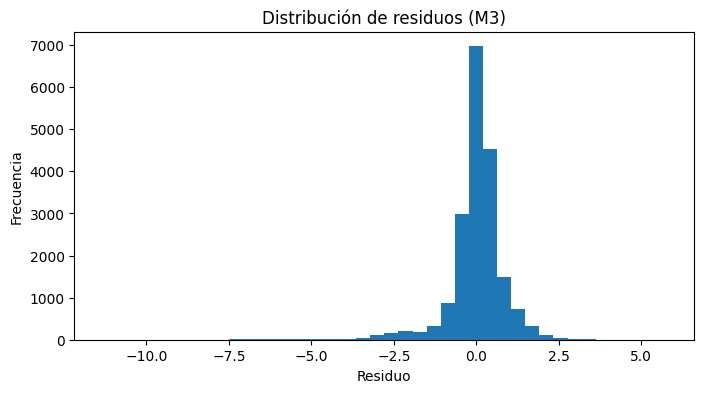

In [27]:
#  Distribución de residuos (M3)
import matplotlib.pyplot as plt

resid = m3.resid

plt.figure(figsize=(8,4))
plt.hist(resid, bins=40)
plt.title("Distribución de residuos (M3)")
plt.xlabel("Residuo")
plt.ylabel("Frecuencia")
plt.show()


### Análisis de la distribución de residuos (M3)

La **distribución de residuos** resume cómo de lejos quedan las observaciones reales del valor predicho por el modelo. Recordemos que para cada individuo:

$$
e_i = y_i - \hat{y}_i
$$

donde $$ yi $$ es `log_salary` observado y $$\hat{y}_i$$ es el `log_salary` predicho por M3.  
- **Residuo positivo**: el salario observado es mayor que el predicho.
- **Residuo negativo**: el salario observado es menor que el predicho.

---

#### ¿Los residuos están centrados cerca de 0?

Sí. En el histograma se observa un pico pronunciado alrededor de **0**, lo que sugiere que, en promedio, el modelo **no está sistemáticamente sesgado** (no “sobrepredice” o “subpredice” de forma generalizada). Esto es lo que se desea en un análisis de distribución de residuos, ya que indica que el ajuste global del modelo es razonable y que el intercepto + covariables capturan una parte importante de la estructura del salario.

---

#### ¿Se observan colas largas / outliers?

Sí. Aunque la mayor parte de los residuos está concentrada cerca de 0, se aprecian:

- **colas** hacia ambos lados, especialmente hacia valores negativos grandes,
- y algunos **residuos extremos** (outliers) alejados del centro.

Esto indica que existen observaciones para las cuales el modelo comete errores grandes: casos donde el salario real es mucho mayor o mucho menor de lo que el modelo esperaría dadas las covariables (país, rol, educación, experiencia y modalidad).

En datos de salario, este patrón es **esperable** incluso tras aplicar transformaciones logarítmicas, por varias razones:

1) **Cola larga natural del salario**  
   Los salarios suelen tener distribución asimétrica y colas pesadas (pocos salarios muy altos y muchos salarios moderados/bajos). El log reduce este fenómeno, pero no lo elimina completamente.

2) **Factores omitidos (no observados)**  
   El modelo controla por variables relevantes, pero el salario depende de muchos otros factores no incluidos (p. ej., industria, tamaño de empresa, nivel real de seniority, tipo de contrato, empresa “tier”, negociación, etc.). Estos factores no modelados se manifiestan como residuos grandes.

3) **Heterogeneidad y posible heterocedasticidad**  
   Es común que la variabilidad del salario (y del error) no sea constante a lo largo del rango de salarios. Por ello, se justifican medidas robustas como el uso de **errores estándar HC3** para inferencia.

Por tanto, podemos afirmar que la presencia de colas/outliers no invalida el análisis, pero indica que el modelo es una aproximación promedio y que existe heterogeneidad relevante. En un contexto salarial, esto refuerza la decisión de (i) trabajar en escala log y (ii) usar inferencia robusta (HC3) para que los intervalos y p-values sean más confiables ante desviaciones de supuestos ideales.


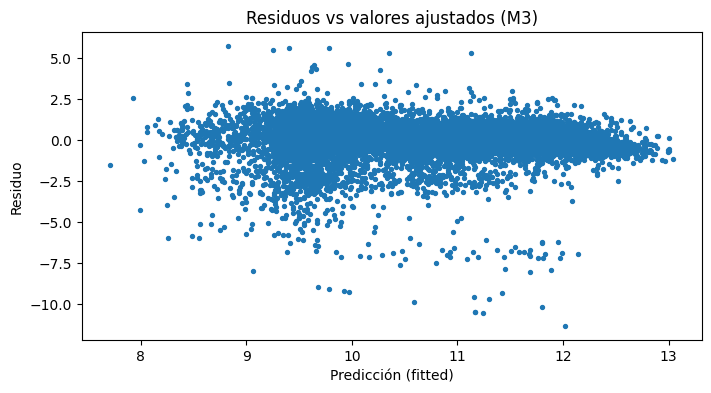

In [23]:
#  Residuos vs valores ajustados (M3)
plt.figure(figsize=(8,4))
plt.scatter(m3.fittedvalues, resid, s=8)
plt.title("Residuos vs valores ajustados (M3)")
plt.xlabel("Predicción (fitted)")
plt.ylabel("Residuo")
plt.show()


### Análisis de residuos vs valores ajustados (M3)

El gráfico **residuos vs valores ajustados** muestra, para cada observación:

- Eje X: $$\hat{y}_i$$ = valor **predicho** por el modelo (`m3.fittedvalues`, en escala `log_salary`)
- Eje Y: $$ e_i = y_i - \hat{y}_i\ $$ = **residuo** del modelo (`m3.resid`)

Su objetivo principal es diagnosticar si el modelo viola supuestos importantes, especialmente:
- **Linealidad** (que el modelo capture adecuadamente la relación media),
- **Homoscedasticidad** (varianza constante de los errores),
- y detectar **outliers / patrones sistemáticos**.

---

#### ¿Los residuos están centrados alrededor de 0 a lo largo del eje X?

En el gráfico, la nube de puntos se distribuye aproximadamente alrededor de la línea horizontal \(e=0\) en la mayor parte del rango de predicciones. Esto sugiere que, globalmente, el modelo no presenta un sesgo fuerte que dependa del nivel de salario predicho (no hay una desviación sistemática clara “hacia arriba” o “hacia abajo” en todo el rango).

---

#### ¿Se observa heterocedasticidad (varianza no constante)?

Sí, se aprecia un patrón de **dispersión desigual**: la nube no mantiene el mismo “grosor” vertical para todos los valores ajustados. En particular, hay zonas donde la variabilidad de los residuos parece mayor, lo cual es un indicio de **heterocedasticidad** (la varianza del error cambia con el nivel de $$\hat{y}$$).

Esto es muy común en datos salariales: la variabilidad relativa del salario puede diferir entre rangos (por ejemplo, perfiles con salarios altos pueden exhibir mayor o menor dispersión dependiendo de factores no observados).

**Implicación:** la heterocedasticidad puede hacer que los errores estándar clásicos sean poco fiables; por ello, el uso de **errores estándar robustos (HC3)** es adecuado y está alineado con el diagnóstico.

---

#### ¿Hay patrones sistemáticos (no linealidad) o outliers?

- No se observa una curva marcada (tipo “U” o patrón claramente estructurado) que sugiera una no linealidad dominante en la relación media.
- Sin embargo, sí aparecen **outliers** y una cola notable de residuos negativos grandes (observaciones con salarios muy por debajo de lo predicho). Esto sugiere heterogeneidad no capturada por el modelo y/o valores atípicos, algo habitual en salarios.

---

#### Interpretación en el contexto del análisis salarial

En conjunto, el gráfico indica que el modelo M3 captura una estructura relevante del salario (residuos centrados), pero:
- la varianza del error no es constante (heterocedasticidad),
- existen observaciones extremas.

Esto refuerza la decisión metodológica de:
1) trabajar con `log_salary` (reduce asimetría y efectos de outliers), y  
2) emplear inferencia robusta HC3 (más confiable bajo heterocedasticidad).

En términos prácticos para RQ2, este diagnóstico no invalida las conclusiones sobre los efectos promedio ajustados de `RemoteWork`, pero sí sugiere interpretar el modelo como una aproximación “promedio” en presencia de heterogeneidad salarial significativa.


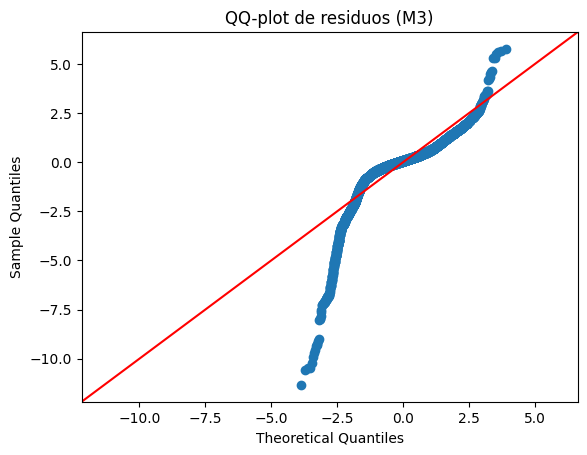

In [16]:
# QQ-plot de residuos (M3)
import statsmodels.api as sm

sm.qqplot(m3.resid, line="45")
plt.title("QQ-plot de residuos (M3)")
plt.show()


### Análisis del QQ-plot de residuos (M3)

El **QQ-plot** (Quantile–Quantile plot) compara los cuantiles de los residuos observados con los cuantiles que se esperarían si los residuos siguieran una **distribución normal**.  
- Eje X: cuantiles teóricos de una normal
- Eje Y: cuantiles muestrales de los residuos

Si los residuos fueran aproximadamente normales, los puntos caerían cerca de la línea de referencia (roja).

---

#### Desviaciones en colas: colas pesadas y asimetría

En el QQ-plot de M3 se observa una desviación marcada de la línea en los extremos:

- En la **cola izquierda** (residuos negativos grandes), los puntos caen muy por debajo de la línea, indicando una **cola izquierda pesada**: existen observaciones con salarios mucho menores que los predichos por el modelo (errores negativos extremos).
- En la **cola derecha** (residuos positivos grandes), los puntos también se separan por encima de la línea, lo que sugiere presencia de **valores positivos extremos** (observaciones con salarios mucho mayores que lo predicho).

Además, la desviación parece más intensa en la cola izquierda que en la derecha, lo cual es compatible con **asimetría** (skewness) y no-normalidad. En conjunto, el QQ-plot sugiere que los residuos tienen **colas más pesadas que una normal** (heavy tails) y no siguen la normalidad de forma estricta.

---

#### Por qué es esperable en un análisis salarial

Este patrón es común en salarios por varias razones estructurales:

1) **Distribución intrínsecamente “heavy-tailed”**  
   Los salarios tienden a mostrar colas largas: una fracción pequeña de individuos reporta salarios excepcionalmente altos, mientras que también existen casos de salarios notablemente bajos.

2) **Heterogeneidad no modelada**  
   Aunque M3 controla por país, rol, educación y experiencia, quedan factores relevantes fuera del modelo (p. ej., industria, empresa, tipo de contrato, seniority real, negociación, tamaño de compañía). Estos factores no observados generan errores grandes para algunos individuos y se manifiestan como colas pesadas.

3) **Posibles valores atípicos / medición**  
   En encuestas pueden existir errores de reporte o casos extremos genuinos (bonos, equity, conversiones monetarias), lo que contribuye a residuos no normales.

---

#### Por qué `log_salary` + HC3 es una mitigación razonable

Dado este diagnóstico, dos decisiones metodológicas del notebook son especialmente apropiadas:

1) **Transformación logarítmica (`log_salary`)**  
   El log reduce la asimetría y atenúa la influencia de salarios extremos al comprimir la escala. En términos prácticos, hace que diferencias multiplicativas (muy típicas en salarios) se vuelvan más lineales y manejables en el modelo.

2) **Errores estándar robustos (HC3)**  
   La no-normalidad y, especialmente, la heterocedasticidad pueden hacer que los errores estándar “clásicos” sean poco fiables. HC3 provee una estimación robusta de la varianza de los coeficientes, haciendo más confiables los intervalos de confianza y p-values aun cuando los supuestos ideales (normalidad/homoscedasticidad) no se cumplen perfectamente.

**Conclusión:** el QQ-plot indica que los residuos no son normales en las colas (colas pesadas y cierta asimetría), lo cual es esperable en datos salariales. Sin embargo, el uso de `log_salary` y de inferencia robusta HC3 mitiga estos problemas de manera razonable para el objetivo del proyecto (evaluar asociaciones promedio ajustadas de `RemoteWork`).


### Conclusiones y respuesta formal a RQ2

Con base en el **modelo final M3** (controlando por `Country`, `YearsCodePro_num`, `EdLevel` y `DevType`):

- `Hybrid` vs `In-person`: el efecto estimado (tabla `remote_effects(m3)`) indica un incremento porcentual aproximado **positivo** con un intervalo de confianza de el 95% completamente por encima de 0.
- `Remote` vs `In-person`: el efecto estimado también es **positivo** con un intervalo de confianza de el 95% completamente por encima de 0.

Por tanto, se puede concluir que la asociación entre `RemoteWork` y salario **se mantiene** tras controlar por país, experiencia, educación y rol (asociación ajustada; no causal).
